<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [114]:

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((448,448)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving content_1.jpg to content_1 (3).jpg

Upload Style Image


Saving style_2.jpg to style_2 (3).jpg
Content Path: <_io.BytesIO object at 0x7f49ebbb3570>
Style Path: <_io.BytesIO object at 0x7f49ebb80db0>


In [0]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates

In [124]:
vgg_names = [         
    "conv1_1", "relu1_1", 
    "conv1_2", "relu1_2", "maxpool1", 
    "conv2_1", "relu2_1", 
    "conv2_2", "relu2_2", "maxpool2", 
    "conv3_1", "relu3_1", 
    "conv3_2", "relu3_2", 
    "conv3_3", "relu3_3","maxpool3", 
    "conv4_1", "relu4_1", 
    "conv4_2", "relu4_2", 
    "conv4_3", "relu4_3","maxpool4", 
    "conv5_1", "relu5_1", 
    "conv5_2", "relu5_2", 
    "conv5_3", "relu5_3","maxpool5"
]

# Choose the layers to use for style and content transfer
content_layers = [
                  19
                  ]
style_layers = [
                0,5,10,17,24
                ]
out_layers = [
              0,5,10,17,24,19
]

# Create the vgg network in eval mode
# with our forward method that returns the outputs of the intermediate layers we requested
content_model = VGGIntermediate(content_layers)
content_model.cuda()

style_model = VGGIntermediate(style_layers)
style_model.cuda()

img_model = VGGIntermediate(out_layers)
img_model.cuda()

# Cache the outputs of the content layers for content image
content_intermediates = content_model(content_image)

# Cache the outputs of the style layers for style image
style_intermediates = style_model(style_image)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**
* Display the style tensor and content tensor transformed back to an image

**DONE:**


In [0]:
# copied and pasted from example for debugging
def imshow(tensors, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image    
    num = len(tensors)
    f, axs = plt.subplots(1,num, figsize=(8*num, 8))
    
    for i in range(len(tensors)):
        image = tensors[i].cpu().clone()  # we clone the tensor to not make changes to the original
        image = image.squeeze(0)          # remove the batch dimension
        image = unloader(image)           # transform the image from a tensor to a PIL image so we can show it.

        p = plt.subplot(1,num,i+1)
        p.imshow(image)
        p.axis('off')
        
        if title is not None:             # Display the title if there is one.
            plt.title(title[i])         

    plt.show()
    plt.pause(0.001)                  # pause a bit so that plots are updated

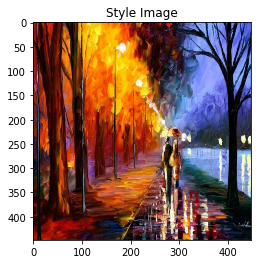

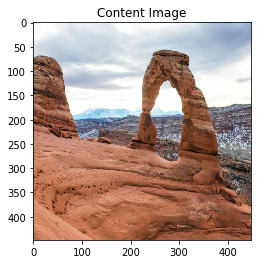

In [119]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')

# for val in style_output.values():
#     plt.figure()
#     display(val, title='Style Tensor')

# plt.figure()
# display(content_output[19], title='Content Tensor')




___

### Part 3
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [0]:
def gram_matrix(input):
    # b = batch size (i.e., 1)
    # f = number of feature maps
    # (h,w) = dimensions of a f. map (N=c*d) 
    b, f, h, w = input.size()

    # resize the input so we can get the gram matrix
    features = input.view(b * f, h * w)

    # calculate the ortho-normal basis
    basis = torch.mm(features, features.t())

    # 'normalize' by dividing by the number of elements in each feature map
    gram = basis.div(b * f * h * w)

    return gram

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()

        # detach ensures we won't backprop into gram matrix
        self.y_truth = gram_matrix(target_feature).detach()

    def forward(self, y_hat):
        G = gram_matrix(y_hat)

        # print(G)
        loss = F.mse_loss(G,self.y_truth)

        return loss


class ContentLoss(nn.Module):
    def __init__(self, y_truth):
        super(ContentLoss, self).__init__()
        self.y_truth = y_truth.detach()

    def forward(self, y_hat):
        loss = F.mse_loss(y_hat, self.y_truth)
        return loss


sl1 = StyleLoss(style_intermediates[0])
sl2 = StyleLoss(style_intermediates[5])
sl3 = StyleLoss(style_intermediates[10])
sl4 = StyleLoss(style_intermediates[17])
sl5 = StyleLoss(style_intermediates[24])


___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



In [0]:
# Start with a copy of the content image
in_img = content_image.clone()

def get_input_optimizer(in_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([in_img.requires_grad_()], lr=.01)
    return optimizer

def run_style_transfer(in_img, num_steps=2000, style_wt=10000, content_wt=1):
    # Run the optimizer on the images to change the image
    #  using the loss of the style and content layers
    #  to backpropagate errors 
    optimizer = get_input_optimizer(in_img)

    # Loop for num steps
    run = [0]
    while run[0] <= num_steps:
        # Stuff from the example
        gc.collect()
        in_img.data.clamp_(0, 1)
        optimizer.zero_grad()

        # Generate y_hat(s) by passing in_img through the model to extract relevant activations
        y_hats = img_model(in_img)

        # Get the loss for each layer
        content_loss = 0
        style_loss = 0

        # content_loss
        for key, content_intermediate in content_intermediates.items():
            content_loss_objective = ContentLoss(content_intermediate)
            cl = content_loss_objective.forward(y_hats[key])
            content_loss += cl
        # style loss
        # for key, style_intermediate in style_intermediates.items():
        #     style_loss_objective = StyleLoss(style_intermediate)
        #     sl = style_loss_objective.forward(y_hats[key])
        #     style_loss += sl
        style_loss += sl1(y_hats[0])
        style_loss += sl2(y_hats[5])
        style_loss += 2*sl3(y_hats[10])
        style_loss += 4*sl4(y_hats[17])
        style_loss += 5*sl5(y_hats[24])



        # Compute total loss as alpha(content_loss) + beta(style_loss)
        content_loss *= content_wt
        style_loss *= style_wt
        loss = content_loss + style_loss
        loss.backward()

        #Every 50 epochs report style and content loss
        run[0] += 1
        if run[0] % 50 == 0:
            print(loss)
            print("epoch {}:".format(run[0]))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_loss.item(), content_loss.item()))
            print()

        # Optimize over the in_img
        optimizer.step()

    # Show the image
    in_img.data.clamp_(0,1)
    return in_img

tensor(79.9810, device='cuda:0', grad_fn=<AddBackward0>)
epoch 50:
Style Loss : 44.050766 Content Loss: 35.930286

tensor(54.2515, device='cuda:0', grad_fn=<AddBackward0>)
epoch 100:
Style Loss : 24.690016 Content Loss: 29.561464

tensor(46.0930, device='cuda:0', grad_fn=<AddBackward0>)
epoch 150:
Style Loss : 19.339779 Content Loss: 26.753246

tensor(43.1463, device='cuda:0', grad_fn=<AddBackward0>)
epoch 200:
Style Loss : 17.720907 Content Loss: 25.425385

tensor(40.2190, device='cuda:0', grad_fn=<AddBackward0>)
epoch 250:
Style Loss : 16.141657 Content Loss: 24.077311

tensor(40.3075, device='cuda:0', grad_fn=<AddBackward0>)
epoch 300:
Style Loss : 17.002748 Content Loss: 23.304722

tensor(37.0608, device='cuda:0', grad_fn=<AddBackward0>)
epoch 350:
Style Loss : 14.032501 Content Loss: 23.028313

tensor(35.9351, device='cuda:0', grad_fn=<AddBackward0>)
epoch 400:
Style Loss : 13.409136 Content Loss: 22.525999

tensor(37.6356, device='cuda:0', grad_fn=<AddBackward0>)
epoch 450:
Style

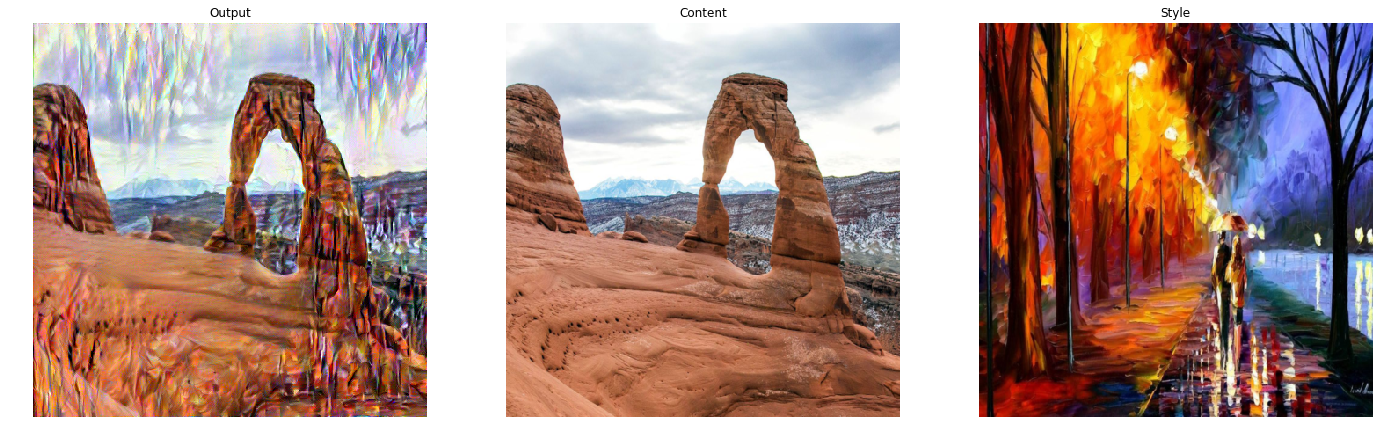

In [147]:
# print(style_loss_funcs.keys())
# print(content_loss_funcs.keys())
# out_model = VGGIntermediate(out_layers)
# out_model.cuda()
# y_hats = out_model(in_img)
# print(y_hats.keys())

output = run_style_transfer(in_img)
imshow([output, content_image, style_image] , title=['Output','Content', 'Style'])

In [0]:
imshow([output, content_image, style_image] , title=['Output','Content', 'Style'])

### Part 5

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

**Equation 1:**
This equation is the loss of the content. In other words, it is a measure of how different the activations on the content layers from the input image are from the activations on the content layers from the content image. p-> is our content image. x-> is the input image. l is the layer. F^l_ij represents the activation of the ith filter at position j in layer l. P^l_ij. i is the filter. j is the position in layer l.

**Equation 3:**
The style representation of an image for layer l. Computed as G^l_ij = sum(F^l_ik * F^l_jk) for all k. In essence G^l_ij is the dot product between feature maps i and j over layer l. This gives us a correlation between the filter responses. F^l_ik is the activation of the ith filter at position k in layer l. Likewise F^l_jk is the activation of the jth filter at position k in layer l

**Equation 4:**
Contribution of layer l to the total loss. E_l = (1/(4(N_l)^2•(M_l)^2)•sum((G^l_ij - A^l_ij)^2) for all i,j). N_l is the number of filters (and subsequently, feature maps) in layer l. M_l is the height•width of the feature map. G^l_ij is the style representation of filter i at position j in layer l of the input image. A^l_ij is the style representation of filter i at position j in layer l of the style image

**Equation 5:**
The total style loss. In other words, it is a measure of how different the activations on the styel layers from the input image are from the activations on the style layers from the style image. a-> is the style image. x-> is the input image. w_l are the weighting factors of the contribution of each layer to the total loss. E_l is the "contribution of layer l to the total loss."